# 概要
効果検証入門の第4章をPythonで実施して同じように推定できるか検証する

### 分析の概要
- カリフォルニア州では1988年から大規模な禁煙キャンペーンが開始
- 1973-1993年のデータを使用
- カリフォルニア州と同様に1988年以降タバコに一定の増税もしくは何らかの規制を行った州とDistrict of Columbia(ワシントンDCのDCの部分)は除外

In [1]:
import numpy as np
import pandas as pd
import polars as pl

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
df_base=pl.read_csv('data/Cigar.csv')
df_base.shape

(1380, 9)

In [4]:
df_base.head()

state,year,price,pop,pop16,cpi,ndi,sales,pimin
i64,i64,f64,f64,f64,f64,f64,f64,f64
1,63,28.6,3383.0,2236.5,30.6,1558.30453,93.9,26.1
1,64,29.8,3431.0,2276.7,31.0,1684.073202,95.4,27.5
1,65,29.8,3486.0,2327.5,31.5,1809.841875,98.5,28.9
1,66,31.5,3524.0,2369.7,32.4,1915.160357,96.4,29.5
1,67,31.6,3533.0,2393.7,33.4,2023.546368,95.5,29.6


In [5]:
# タバコの規制を行っていた州とタバコの税金が1988年以降に50セント以上上がった州のリスト
LST_SKIP_STATE=[3, 9, 10, 21, 22, 23, 31, 33, 48]

df_select = (df_base
             .select(['sales', 'state', 'year', 'pop16'])
             .filter(pl.col("year")>=70 , ~pl.col("state").is_in(LST_SKIP_STATE)
                    )
             .with_columns(pl.when(pl.col("state") == 5).then(1).otherwise(0).alias('ca_flg'))
             .with_columns(pl.when(pl.col("year") > 87).then(1).otherwise(0).alias('post'))
             .with_columns((pl.col("ca_flg")*pl.col("post")).alias('ca_flg * year_dummy'))
             .with_columns(pl.lit('D').alias('tmp'))
             .with_columns(pl.concat_str([pl.lit('D'), pl.col("year")], separator="_").alias('year_dummy'))

            )

# カリフォルニア州とその他の州の2グループのデータを作成
df_sum=(df_select
 .select(['sales', 'ca_flg', 'post', 'year', 'ca_flg * year_dummy', "year_dummy", 'pop16'])
 .group_by(['ca_flg', 'post', 'year', 'ca_flg * year_dummy', "year_dummy"])
 .agg((pl.col("sales")*pl.col("pop16")).sum()/pl.col("pop16").sum())
 .sort("year", "ca_flg", descending=[False, True])
 )

In [6]:
# yearのダミー変数
_pdf=(pl.concat([df_sum[['ca_flg', 'post', 'ca_flg * year_dummy', 'sales']]
                , df_sum[['year_dummy']].to_dummies(drop_first=True)]
                , how="horizontal")
     .to_pandas()
    )

# DIDによる推定

### statsmodels

In [7]:
import statsmodels.api as sm

_X = sm.add_constant(_pdf.drop(columns='sales'))
# 被説明変数
_Y = _pdf["sales"]

# OLSの実施
model = sm.OLS(_Y, _X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     13.13
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           5.98e-08
Time:                        16:11:32   Log-Likelihood:                -131.32
No. Observations:                  46   AIC:                             312.6
Df Residuals:                      21   BIC:                             358.4
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 123.5615    

### 可視化してトレンドを確認

### pingouin

In [8]:
import pingouin as pg
pg.linear_regression(_pdf.drop(columns='sales'), _pdf["sales"])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,123.561534,4.519375,27.340401,6.686611e-18,0.93751,0.866093,114.162979,132.960090
1,ca_flg,-9.089784,2.073632,-4.383510,2.597039e-04,0.93751,0.866093,-13.402137,-4.777431
2,post,-13.856860,4.422532,-3.133241,5.022746e-03,0.93751,0.866093,-23.054019,-4.659700
3,ca_flg * year_dummy,-20.543519,4.447444,-4.619174,1.479716e-04,0.93751,0.866093,-29.792485,-11.294552
4,year_dummy_D_71,0.542142,6.220895,0.087149,9.313791e-01,0.93751,0.866093,-12.394917,13.479201
5,year_dummy_D_72,3.161948,6.220895,0.508279,6.165559e-01,0.93751,0.866093,-9.775111,16.099006
6,year_dummy_D_73,4.593108,6.220895,0.738336,4.684823e-01,0.93751,0.866093,-8.343951,17.530167
7,year_dummy_D_74,7.803582,6.220895,1.254415,2.234744e-01,0.93751,0.866093,-5.133477,20.740641
8,year_dummy_D_75,8.848502,6.220895,1.422384,1.695994e-01,0.93751,0.866093,-4.088557,21.785560
9,year_dummy_D_76,11.381811,6.220895,1.829610,8.154301e-02,0.93751,0.866093,-1.555247,24.318870


### 平行トレンドの確認

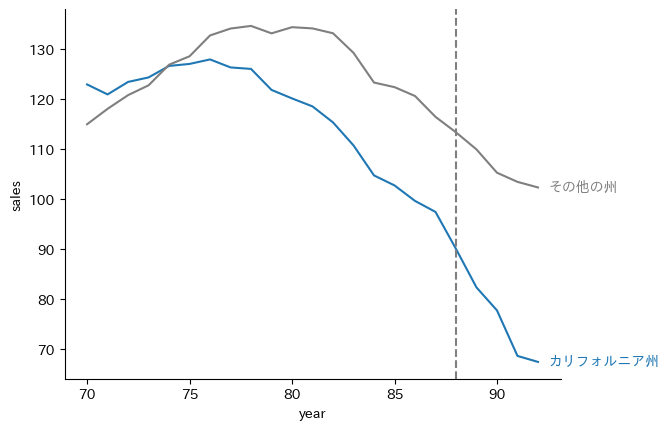

In [9]:
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.plot(df_sum.filter(pl.col('ca_flg')==1)['year']
         , df_sum.filter(pl.col('ca_flg')==1)['sales']
         , color='tab:blue'
         )
plt.plot(df_sum.filter(pl.col('ca_flg')==1)['year']
         , df_sum.filter(pl.col('ca_flg')==0)['sales']
         , color='tab:grey'
         )
plt.axvline(x=88, linestyle='--',color='tab:gray')
plt.ylabel('sales')
plt.xlabel('year')

lst_y=[df_sum.filter(pl.col('ca_flg')==0)['sales'][-1], df_sum.filter(pl.col('ca_flg')==1)['sales'][-1]]
lst_label=['その他の州', 'カリフォルニア州']
lst_col=['grey','tab:blue']
for i in range(2):
    plt.text(92.5, lst_y[i], lst_label[i], ha='left', va='center',color=lst_col[i])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
    
plt.show()
plt.close()

並行トレンドではないと判断して別の方法による推定が必要と判断

# Causalimpactによる推定

In [10]:
# 目的変数の作成
ci_Y = (df_base
        .filter(pl.col('state')==5
                , pl.col("year") >= 70
               )
        .select(['year', 'sales'])
        .rename({"sales": "Y"})
       )
# 説明変数の作成
ci_x_sales=(df_base
            .filter(pl.col('state')!=5
                    , pl.col("year") >= 70
                    )
            .pivot(index="year", columns="state", values="sales")
           )

In [11]:
df_ci=ci_Y.join(ci_x_sales, on=['year']).to_pandas()
df_ci_index_year = df_ci.set_index('year')
df_ci_index_year.head(1)

,Y,1,3,4,7,8,9,10,11,13,...,42,43,44,45,46,47,48,49,50,51
year,,,,,,,,,,,,,,,,,,,,,
70,123.0,89.8,115.2,100.3,120.0,155.0,200.4,123.6,109.9,102.4,...,92.7,99.8,106.4,65.5,122.6,124.3,96.7,114.5,106.4,132.2


# tfp-causalimpact
- https://github.com/google/tfp-causalimpact/blob/main/docs/quickstart.ipynb

In [12]:
# 必要であれば下記二つをinstall
# !pip install tfp-causalimpact
# !pip install tf-keras

In [17]:
import causalimpact

In [14]:
impact = causalimpact.fit_causalimpact(
    data=df_ci_index_year
    , pre_period=(0, 17)
    , post_period=(18, 22)
)

In [15]:
causalimpact.plot(impact)

alt.FacetChart(...)

In [16]:
print(causalimpact.summary(impact, output_format='summary'))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    77.3               386.5
Prediction (s.d.)         89.5 (6.06)        447.7 (30.31)
95% CI                    [76.3, 100.8]      [381.4, 503.8]

Absolute effect (s.d.)    -12.2 (6.06)       -61.2 (30.31)
95% CI                    [-23.5, 1.0]       [-117.3, 5.1]

Relative effect (s.d.)    -13.3% (6.1%)      -13.3% (6.0%)
95% CI                    [-23.3%, 1.3%]     [-23.3%, 1.3%]

Posterior tail-area probability p: 0.036
Posterior prob. of a causal effect: 96.45%

For more details run the command: summary(impact, output_format="report")
